In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
import itertools
import fnmatch
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from keras.utils.np_utils import to_categorical
%matplotlib inline

In [2]:
files = listdir("breast-histopathology-images/")
base_path = "breast-histopathology-images/IDC_regular_ps50_idx5/"
folder = listdir(base_path)
total_images = 0
imagePatches = []
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for s in subfiles:
            imagePatches.append(class_path + s)
        total_images += len(subfiles)

for i in imagePatches[:10]:
    print(i)

breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1001_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1051_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1101_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1151_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1201_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1251_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1301_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1351_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1501_class0.png
breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1551_class0.png


In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1001_class0.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1051_class0.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1101_class0.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1151_class0.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['breast-histopathology-images/IDC_regular_ps50_idx5/10253/1/10253_idx5_x501_y351_class1.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/1/10253_idx5_x501_y401_class1.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/1/10253_idx5_x551_y301_class1.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/1/10253_idx5_x551_y351_class1.png', 'breast-histopathology-images/IDC_regular_ps50_idx5/10253/1/10253_idx5_x551_y401_class1.png']


In [4]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays:
        x is an array of resized images
        y is an array of labels
    """
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = plt.imread(img, format=None)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [5]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1]

In [6]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 90000
Number of IDC(-) Images: 64583
Number of IDC(+) Images: 25417
Percentage of positive images: 28.24%
Image shape (Width, Height, Channels): (50, 50, 3)


In [7]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)


                                              images  labels
0  [[[0.8862745, 0.6431373, 0.80784315], [0.87843...       0
1  [[[0.85882354, 0.5882353, 0.77254903], [0.8509...       0
2  [[[0.972549, 0.9607843, 0.9764706], [0.972549,...       0
3  [[[0.9764706, 0.96862745, 0.9764706], [0.97647...       0
4  [[[0.94509804, 0.90588236, 0.92941177], [0.964...       0
5  [[[0.972549, 0.9647059, 0.972549], [0.972549, ...       0
6  [[[0.83137256, 0.47058824, 0.6862745], [0.6862...       0
7  [[[0.5568628, 0.14901961, 0.34117648], [0.6470...       0
8  [[[0.9411765, 0.89411765, 0.92156863], [0.9647...       0
9  [[[0.9490196, 0.8745098, 0.93333334], [0.94509...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


In [11]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (72000, 50, 50, 3)
Testing Data Shape: (18000, 50, 50, 3)


In [13]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)


C:\Users\Perdorues\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


{0: 'IDC(-)', 1: 'IDC(+)'}


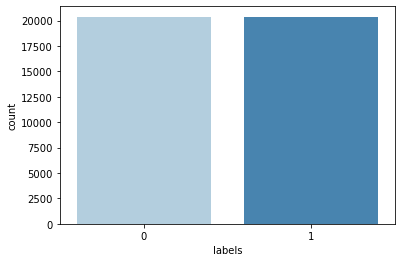

In [15]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler()
ros = RandomUnderSampler()
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos, palette="Blues")
print(dict_characters)

In [16]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)


Old Class Weights:  [0.6973906  1.76652436]
New Class Weights:  [1. 1.]


C:\Users\Perdorues\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1

In [18]:
#runLogisticRegression
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

LogisticRegression - Training set accuracy: 0.7663333333333334 (0.009782195971492859)




Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:

[0.80041 0.80252 0.81017 0.7984  0.80035 0.79936 0.78127 0.77768 0.82087
 0.81555]
SVM: 0.800658 (0.012787)
[0.76791 0.77207 0.75974 0.77359 0.77478 0.76731 0.77249 0.76143 0.7604
 0.77309]
LR: 0.768281 (0.005556)
[0.78536 0.78615 0.79068 0.78438 0.79493 0.78704 0.79897 0.78597 0.79153
 0.79322]
GNB: 0.789823 (0.004589)
[0.71259 0.70802 0.70825 0.7085  0.71055 0.70136 0.71843 0.71917 0.71283
 0.72047]
DT: 0.712017 (0.005683)
[0.76479 0.764   0.76705 0.75821 0.76209 0.7625  0.76434 0.75997 0.75816
 0.76299]
KNN: 0.762410 (0.002749)


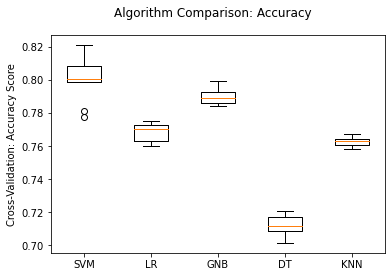


LR = LogisticRegression
RF = RandomForestClassifier
KNN = KNeighborsClassifier
SVM = Support Vector Machine SVC
LSVM = LinearSVC
GNB = GaussianNB
DTC = DecisionTreeClassifier



In [19]:
def compareClassicModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('SVM', SVC()))
    models.append(('LR', LogisticRegression()))
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('KNN', KNeighborsClassifier()))

    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareClassicModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)


def defineModels():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('')
    print('SVM = Support Vector Machine SVC')
    print('LR = LogisticRegression')
    print('GNB = GaussianNB')
    print('DTC = DecisionTreeClassifier')
    print('KNN = KNeighborsClassifier')
    print('')
    return
defineModels()
